# Notebook for analysis of TM - SS2 pseudobulk and single cell GRN

## Imports

In [1]:
#Import libraries
import os
import glob
import pickle
import pandas as pd
import numpy as np
from pyscenic.aucell import aucell
import seaborn as sns
import scanpy
import scanpy.api as sc
from matplotlib import pyplot as plt
from sklearn import preprocessing
import matplotlib

/home/andreas/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/andreas/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/andreas/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
#Set figure parameters
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
scanpy.api.set_figure_params(scanpy=True, dpi=80, dpi_save=1200, frameon=True, vector_friendly=True)

# Preprocess scanpy objects

In [3]:
from RegulonPreprocessing import preprocess_pb

In [4]:
droplet, facs, mca = preprocess_pb('data')

Loading datasets
Subsetting genes (expressed in 10% of cells in all datasets)


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.obs` of view, copying.


Normalizing


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Log transforming
Detecting highly variable genes
Regressing out: # counts and % mito
Scaling


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Removing unannotated cells
Annotating datasets


In [5]:
#Read colormap
colormap = pd.read_csv('data/ColorMap.csv', sep=';')

# Expression space

In [6]:
di = {cell:color for cell,color in zip(colormap['celltype'], colormap['color_grad'])}
facs.uns['celltype_colors'] = [di[x] for x in facs.obs['celltype'].cat.categories]

In [8]:
sc.tl.pca(facs, svd_solver='arpack')


... storing 'protocol' as categorical
... storing 'phase' as categorical


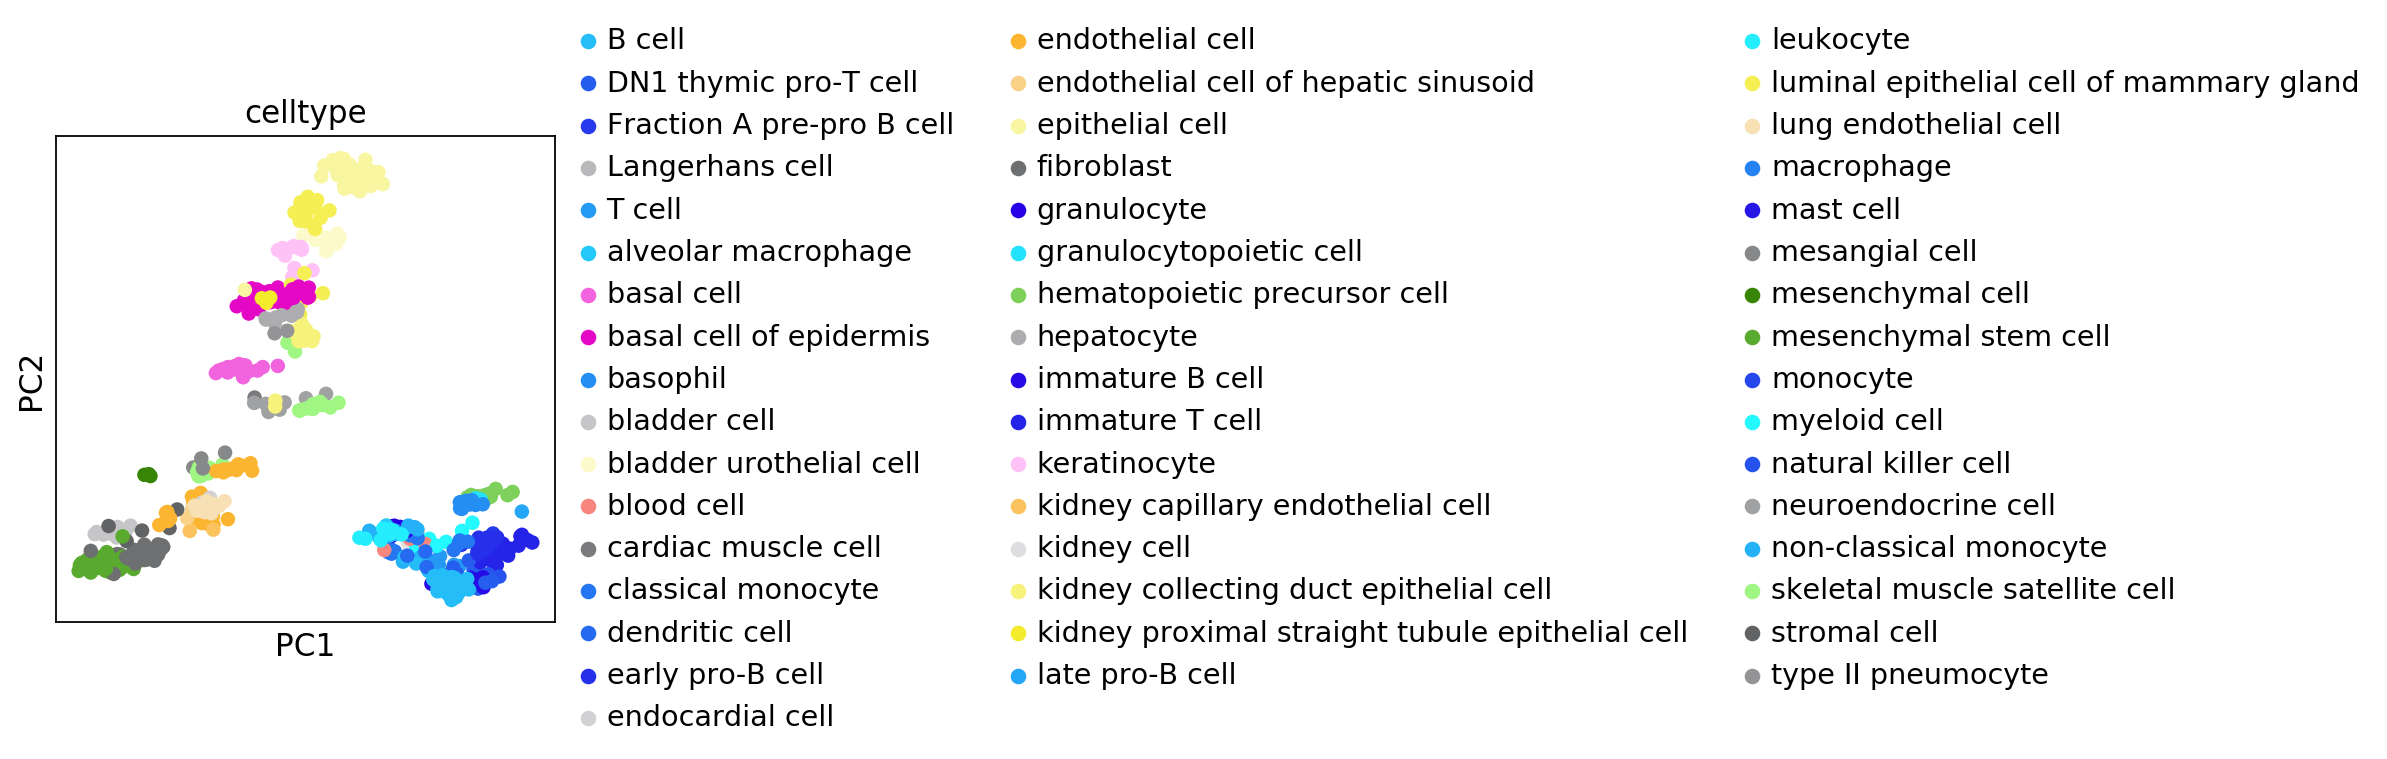

In [9]:
sc.pl.pca(facs, color='celltype')


In [10]:
sc.pp.neighbors(facs, n_neighbors=10, n_pcs=10)


In [11]:
sc.tl.umap(facs)


/home/andreas/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


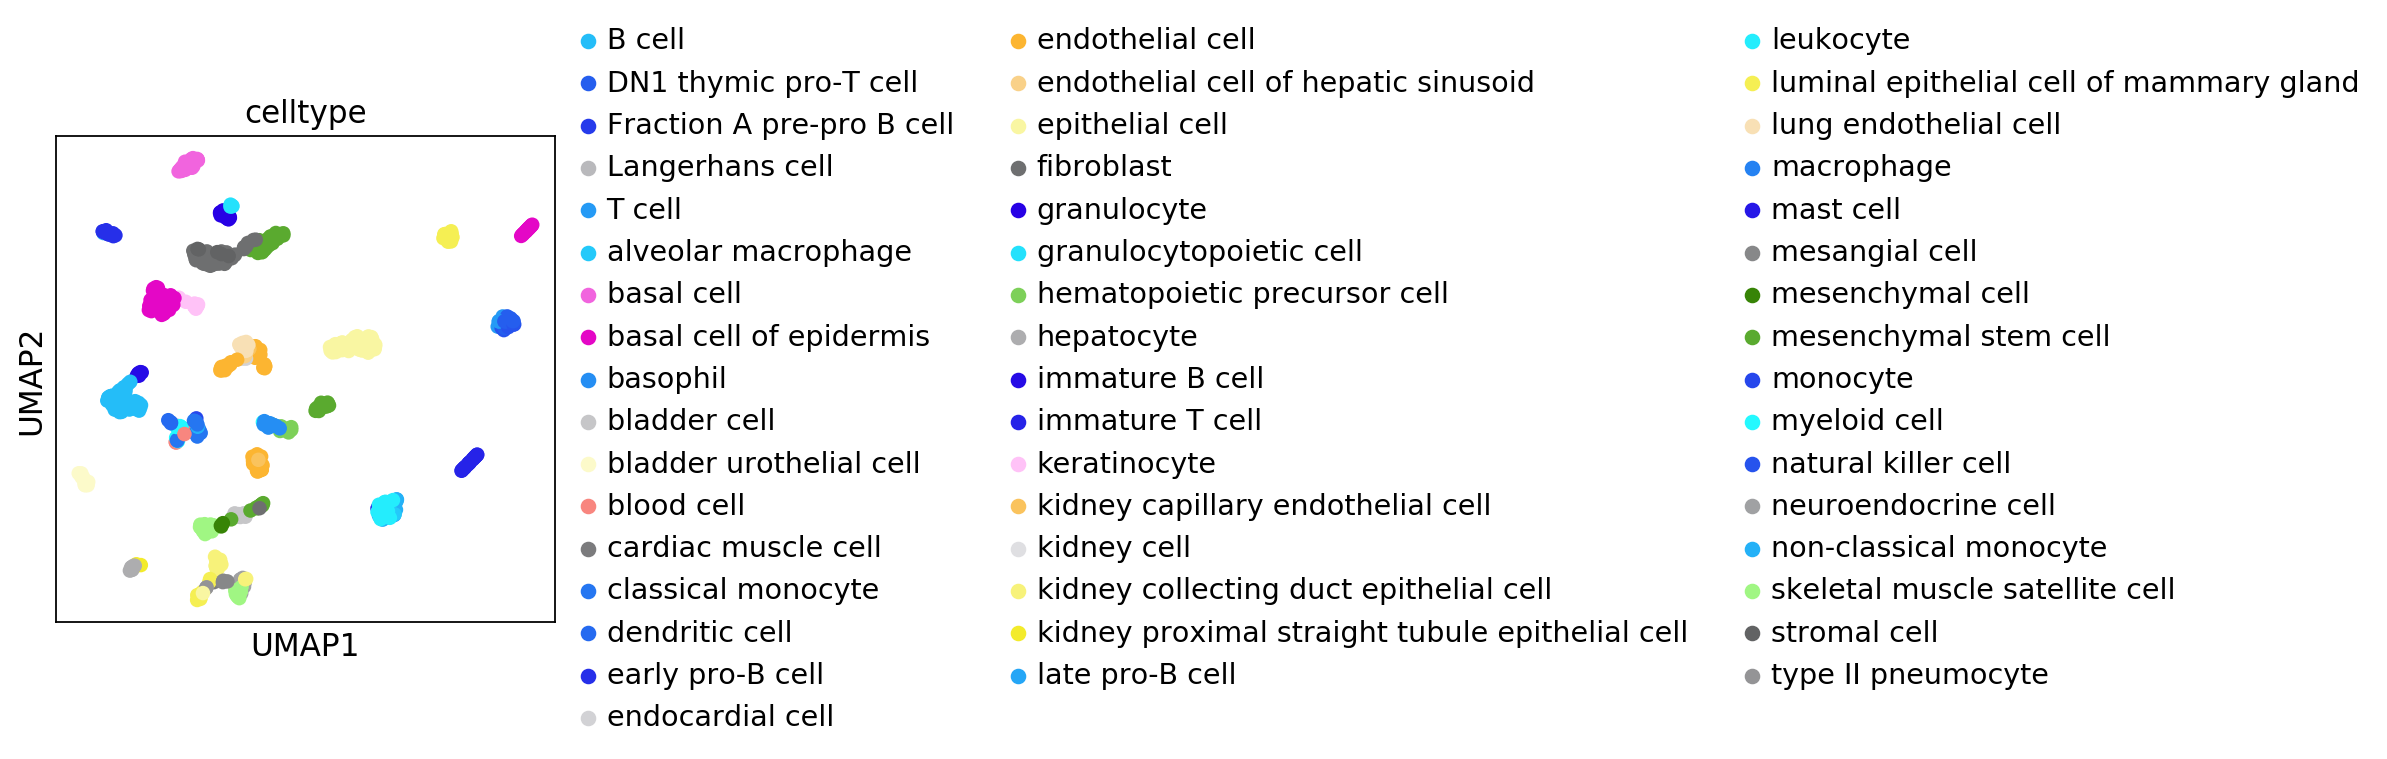

In [12]:
sc.pl.umap(facs, color=['celltype'])


# Regulon space

In [7]:
#Settings
DATA_FOLDER="/home/andreas/Documents/notebooks/MCA_TM/SCENIC/database_SCENIC/tmp/facs"
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons_10_percent.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs_10_percent.csv")

In [8]:
#Reload precomputed regulons
with open(REGULONS_FNAME, "rb") as f:
    regulons_facs = pickle.load(f)

In [9]:
#make expression matrix
ex_matrix = facs.X
ex_matrix = pd.DataFrame(data= ex_matrix,
                              index=facs.obs.index.tolist(),
                              columns=facs.var.index.tolist())
        
#calculate regulon AUC
facs_auc_mtx = aucell(ex_matrix, regulons_facs, num_workers=24)

In [10]:
from RegulonAnalysis import RegulonsAnalysis

In [11]:
#initialize regulon object
facs1 = RegulonsAnalysis( regulons_facs,  facs, facs_auc_mtx)


PCA not computed - using 5 principal components


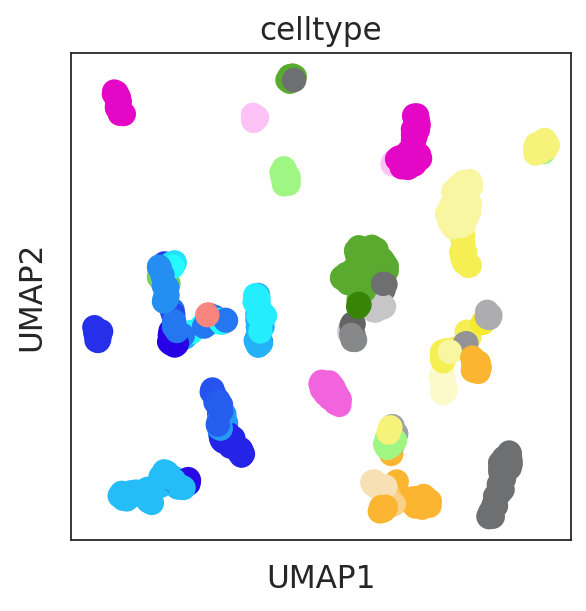

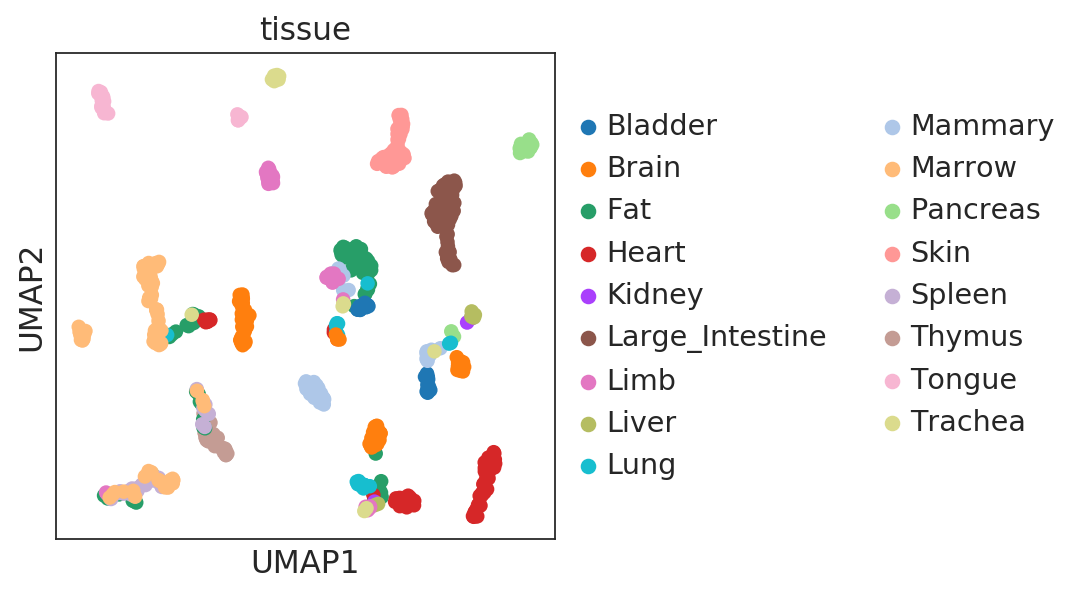

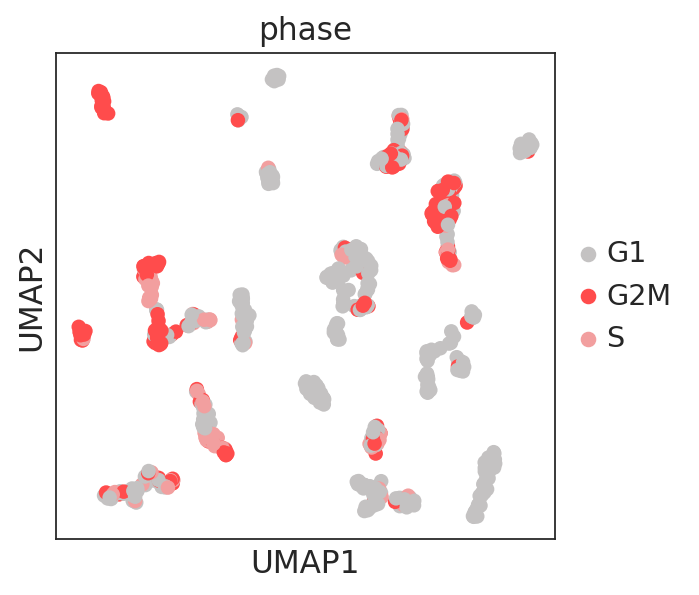

In [18]:
facs1.plot('umap', 'celltype', color_index=colormap, pcs= 5, color_index_type='color_grad')
facs1.plot('umap', 'tissue', color_index=colormap, pcs= 5, color_index_type='color_grad')
facs1.plot('umap', 'cellcycle', color_index=colormap, pcs= 5, color_index_type='color_grad')

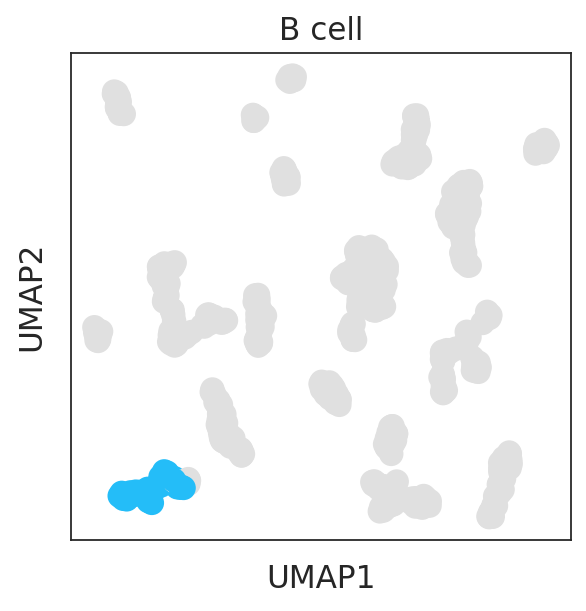

In [19]:
facs1.plot_by_celltype_ind(Type='B cell',dr ='umap', color_index=colormap, pcs= 5)

Plot a few regulon activities

## Cell to cell correlation based on RAS

/home/andreas/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


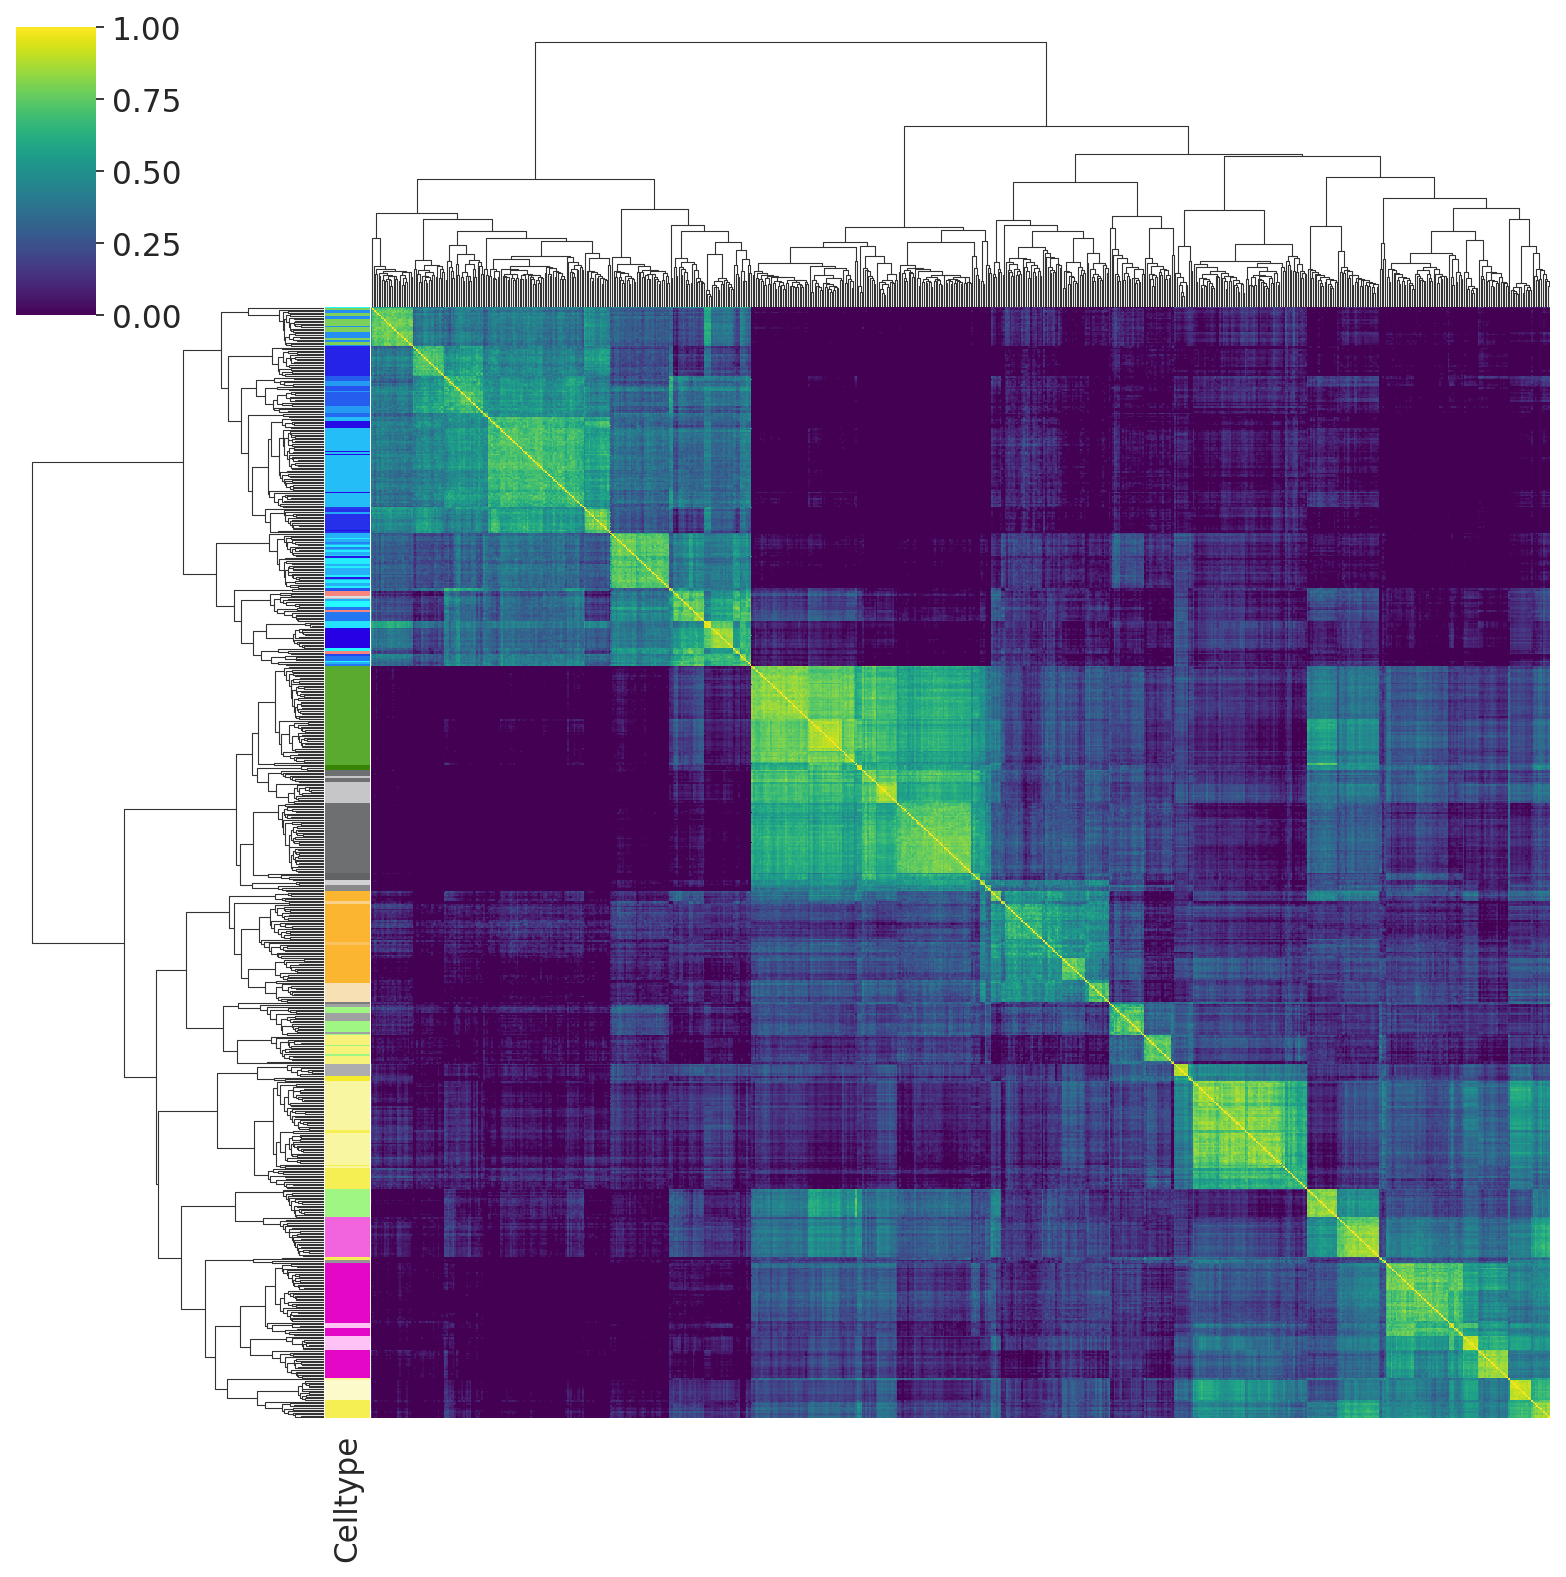

In [20]:
#remember to calculate tsne with celltypes before. Or else, celltype_colors will not be stored in the scanpy object
facs1.cell_regulon_cor(color_index = colormap, color_by='color_grad')


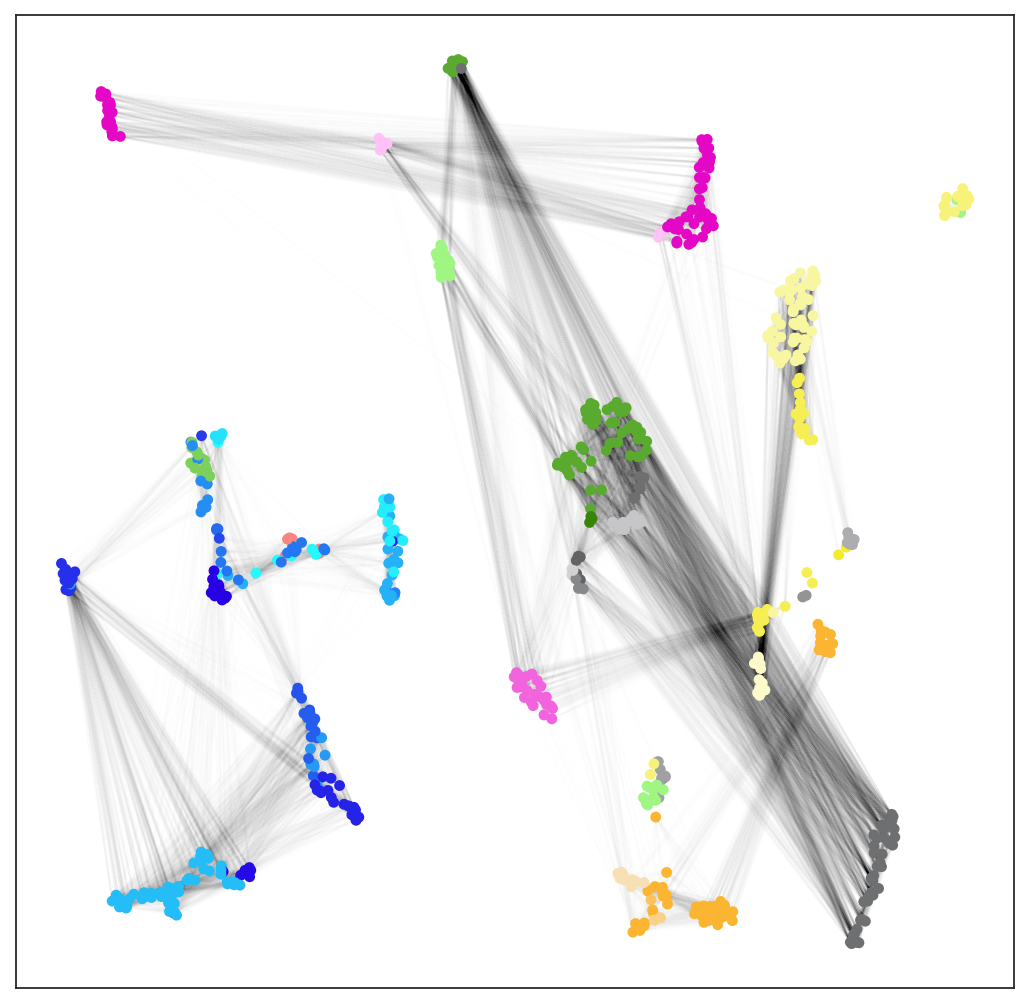

In [21]:
facs1.cell_regulon_network(0.50, color_index = colormap, dr='umap', pcs=5, color_by = 'color_grad', save = 'data/pseudobulk_tsne_facs.gexf')

/home/andreas/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


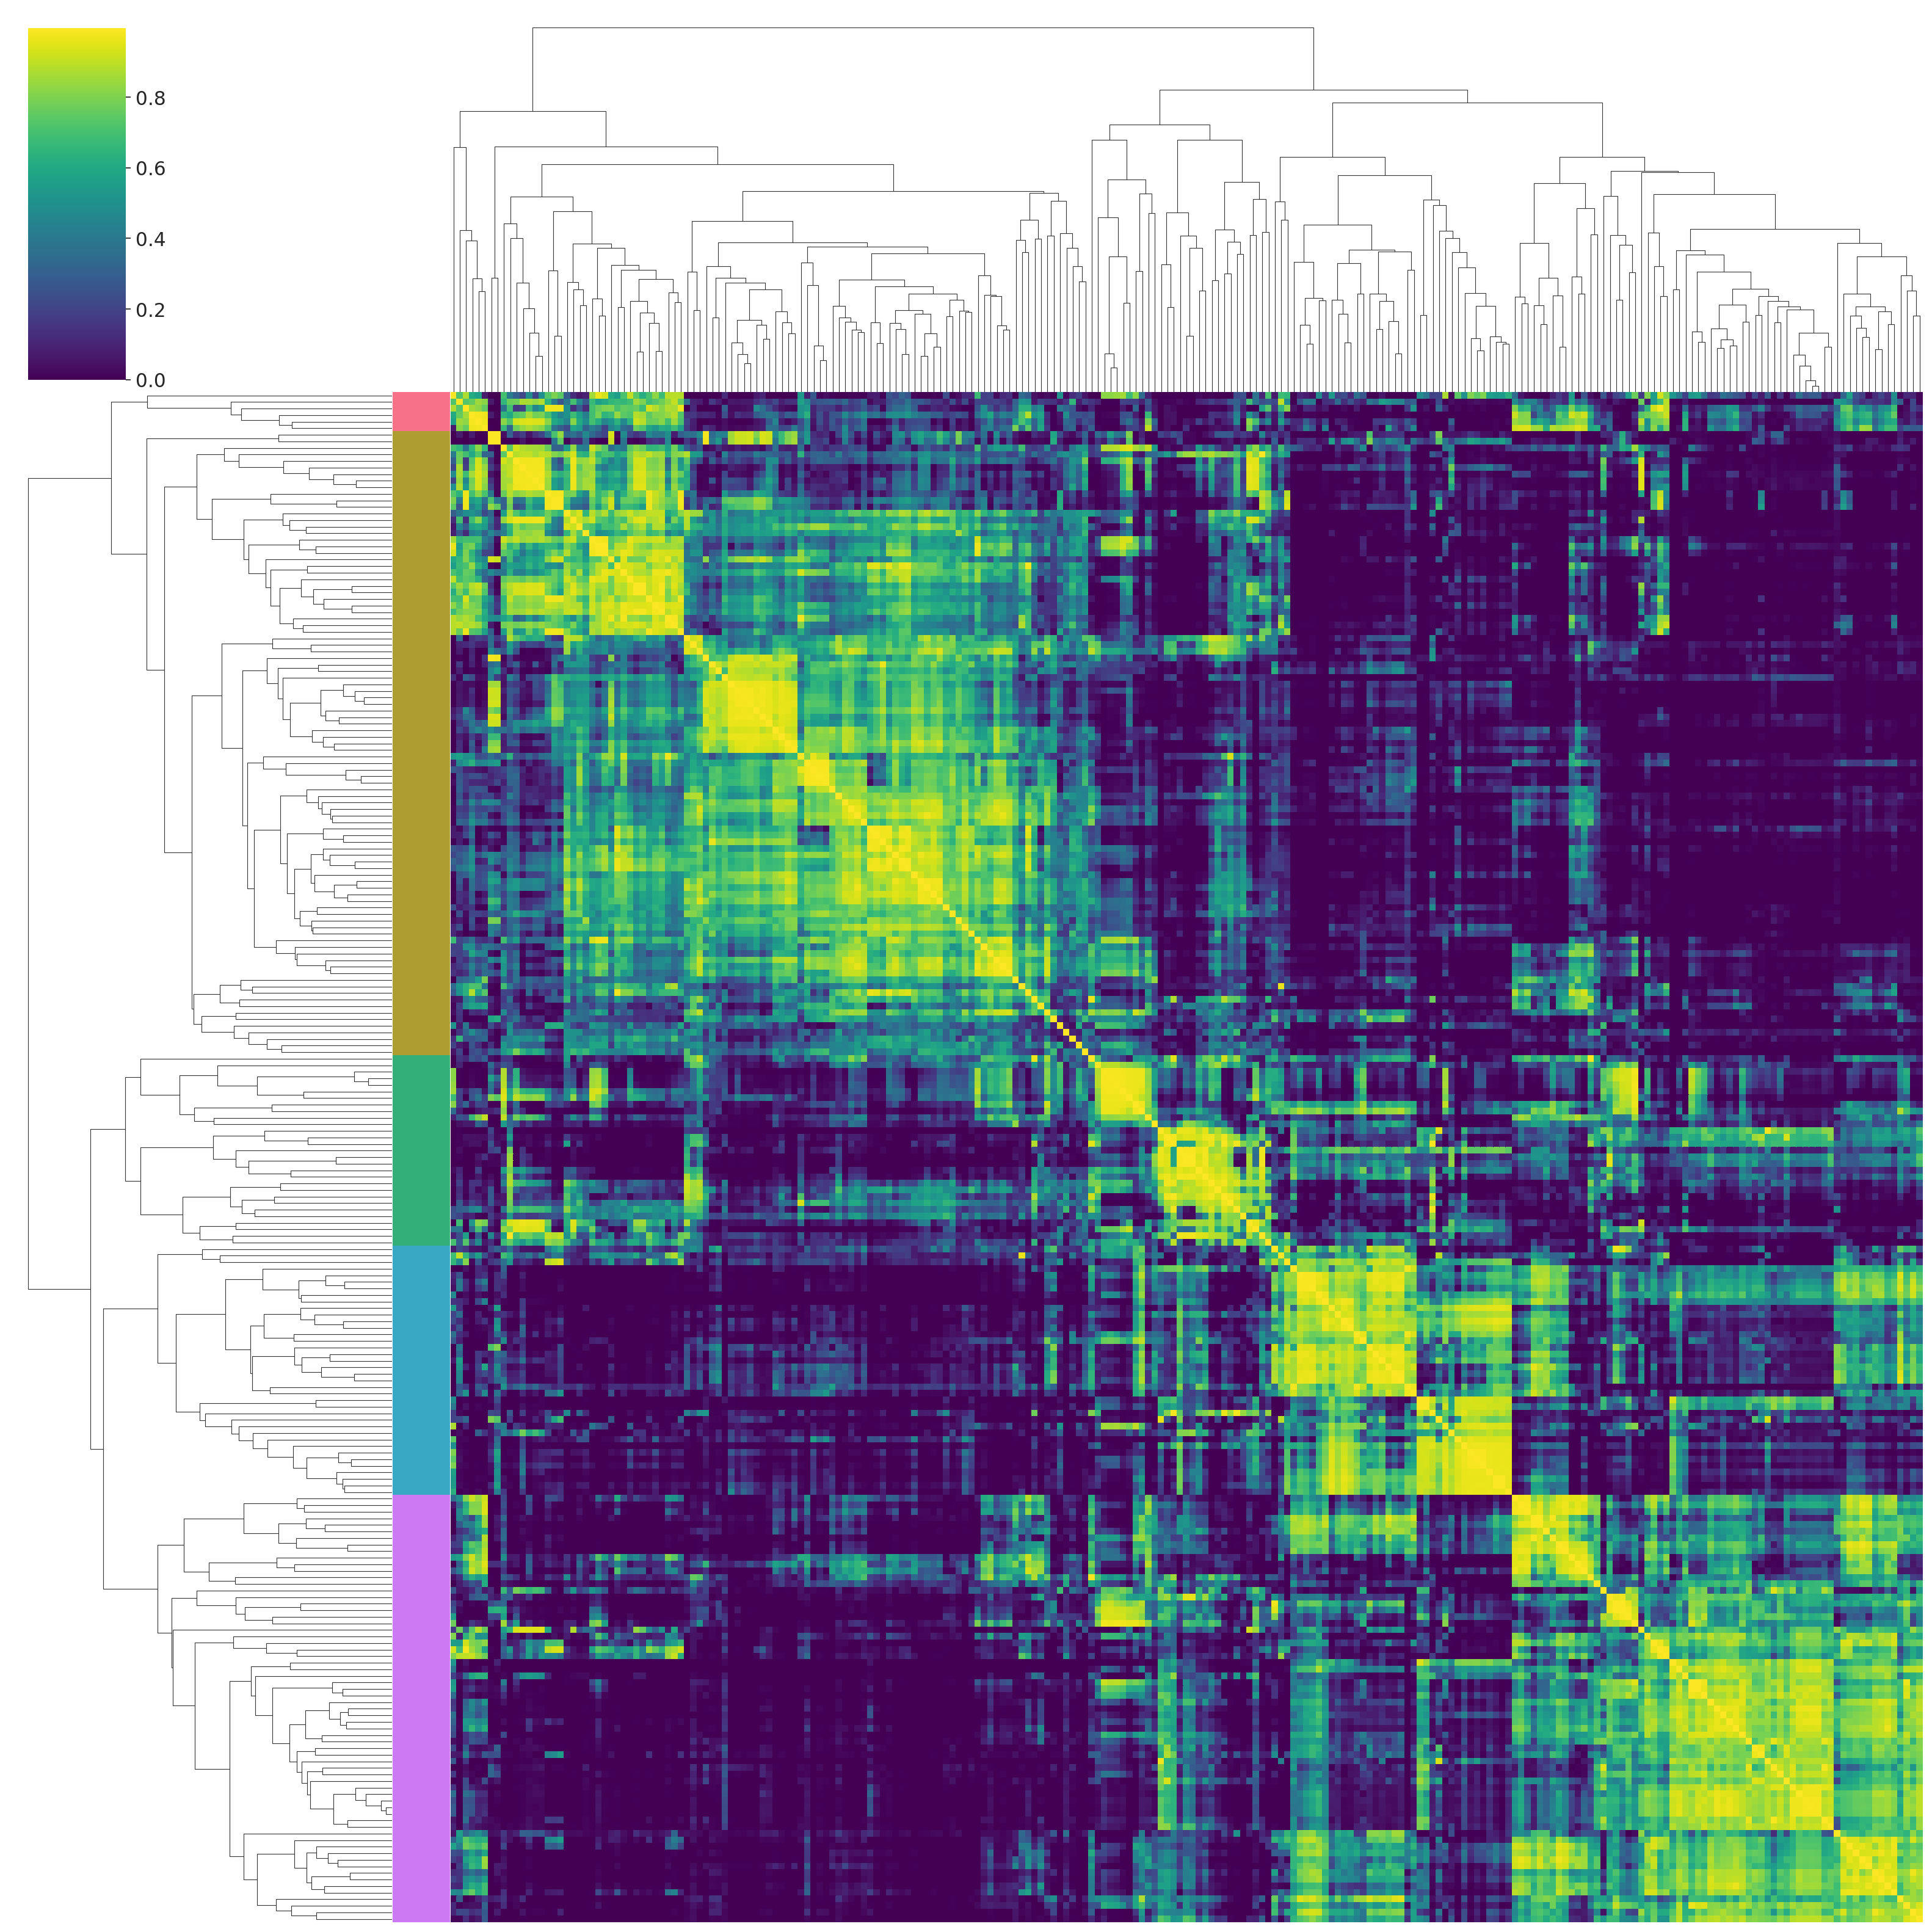

In [22]:
facs1.plot_csi()




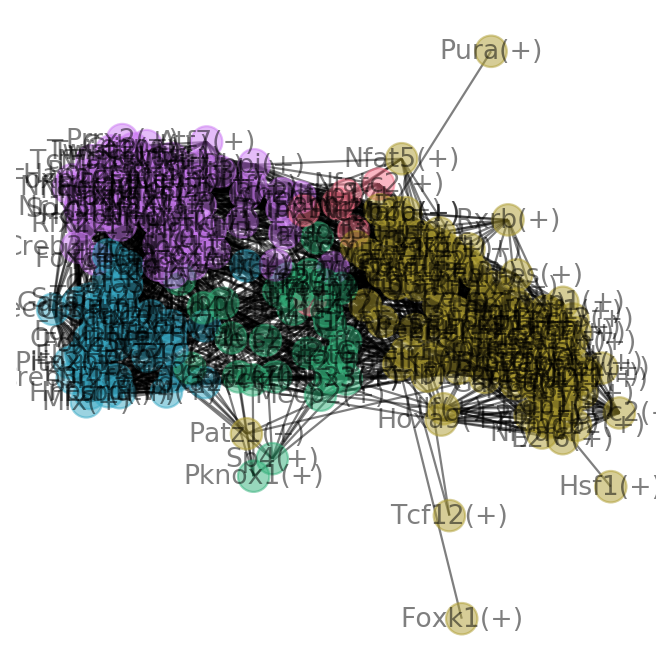

In [23]:
facs1.regulon_network(0.70, save = 'data/regulon_network_facs_pseudobulk_5clust.gexf', lut=None)


# single-cell cleaning

In [12]:
facs = sc.read('data/tm_facs_scanpy_no_processing.h5ad')


#getting annotation from scmap projection of droplet
facs_ann = pd.read_csv('data/facs_annotation_projected_from_drop.tsv', sep= '\t')

#getting annotation from scmap projection of droplet
facs.obs['original_annotation'] =  facs_ann['original'].values
facs.obs['from_droplet'] =  facs_ann['projected_drom_droplet'].values

In [13]:
#Number of cells before processing
print(facs.n_obs)

53760


Remove cells not annotated by author

In [14]:
facs.obs['cell_ontology_class'].replace(np.NaN, 'Non-annotated', inplace = True)
facs = facs[facs.obs['cell_ontology_class'] != 'Non-annotated']

Remove cells with no matched from scmap 

In [15]:
facs.obs['celltype'] = pd.Categorical(facs.obs['from_droplet'])
facs = facs[facs.obs['celltype'] != 'unassigned']
facs = facs[[type(i) == str for i in facs.obs['cell_ontology_class']]]

Trying to set attribute `.obs` of view, copying.


In [16]:
facs.obs['n_counts'] = facs.X.sum(axis=1).A1
sc.pp.calculate_qc_metrics(facs, inplace = True)

Trying to set attribute `.obs` of view, copying.


In [17]:
from RegulonPreprocessing import stats

In [18]:
stats([facs], ['TM-SS2'])

TM-SS2
# Tissues              18.000000
Mean Counts        851056.625000
Median Counts      721598.500000
Mean Genes           3266.472794
Median Genes         3024.000000
Author cell-types      81.000000
Cells               38888.000000

In [19]:
#library size normalization
sc.pp.normalize_per_cell(facs, counts_per_cell_after=1e4)

#log transform
sc.pp.log1p(facs)

In [20]:
mito_genes_facs = facs.var_names.str.startswith('Mt')

In [21]:
facs.obs['percent_mito'] = np.sum(
    facs[:, mito_genes_facs].X) / np.sum(facs.X)

In [22]:
facs.obs['n_counts'] = facs.X.sum(axis=1).A1

In [23]:
sc.pp.filter_genes(facs, min_counts=1)


In [24]:
facs.obs['protocol'] = 'Smartseq2'

In [25]:
from RegulonPreprocessing import score_cell_cycle
score_cell_cycle(facs)


In [115]:
facs_auc_mtx = pd.read_csv('data/facs_auc_mtx.csv', index_col = 0)

In [116]:
facs.X = facs.X.todense()

In [ ]:
facs_all = RegulonsAnalysis( regulons_facs,  facs, facs_auc_mtx)
facs_all.plot('umap', 'celltype', color_index=colormap, pcs= 10, color_index_type='color_grad', point_size = 1)
facs_all.plot('umap', 'original_annotation', color_index=colormap, pcs= 10, color_index_type='color_grad', point_size = 1)
facs_all.plot('umap', 'tissue', color_index=colormap, pcs= 10, color_index_type='color_grad')
facs_all.plot('umap', 'cellcycle', color_index=colormap, pcs= 10, color_index_type='color_grad')

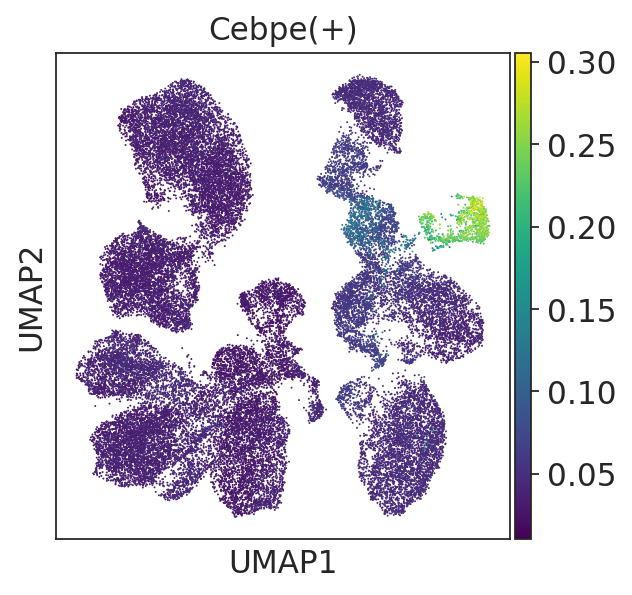

In [118]:
facs_all.plot('umap', 'Cebpe(+)', color_index=colormap, pcs= 5)


## Regulon specificity

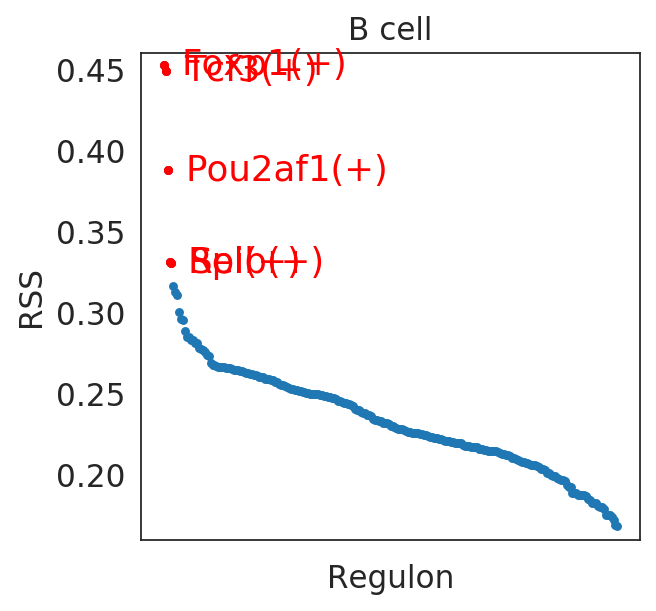

In [119]:
facs_all.plot_regulon_specificity_celltype('B cell')

## scmap mapping tables

In [34]:
#Mapping celltypes between datasets can be quantified as:
facs.obs.groupby(['cell_ontology_class', 'from_droplet']).count().reset_index().pivot_table(
    index = 'cell_ontology_class', columns = 'from_droplet', values = 'plate_barcode').head()#.to_csv('facs_scmap_matrix.csv')

from_droplet                                        B cell  \
cell_ontology_class                                          
B cell                                              1836.0   
Bergmann glial cell                                    NaN   
Brush cell of epithelium proper of large intestine     NaN   
DN1 thymic pro-T cell                                  NaN   
Kupffer cell                                           NaN   

from_droplet                                        DN1 thymic pro-T cell  \
cell_ontology_class                                                         
B cell                                                                7.0   
Bergmann glial cell                                                   NaN   
Brush cell of epithelium proper of large intestine                    NaN   
DN1 thymic pro-T cell                                                31.0   
Kupffer cell                                                          NaN   

from_droplet                                        Fraction A pre-pro B cell  \
cell_ontology_class                                                             
B cell                                                                    2.0   
Bergmann glial cell                                                       NaN   
Brush cell of epithelium proper of large intestine                        NaN   
DN1 thymic pro-T cell                                                     NaN   
Kupffer cell                                                              NaN   

from_droplet                                        Langerhans cell  T cell  \
cell_ontology_class                                                           
B cell                                                          2.0     2.0   
Bergmann glial cell                                             NaN     NaN   
Brush cell of epithelium proper of large intestine              NaN     NaN   
DN1 thymic pro-T cell                                           NaN     NaN   
Kupffer cell                                                    NaN     NaN   

from_droplet                                        alveolar macrophage  \
cell_ontology_class                                                       
B cell                                                              NaN   
Bergmann glial cell                                                 NaN   
Brush cell of epithelium proper of large intestine                  NaN   
DN1 thymic pro-T cell                                               NaN   
Kupffer cell                                                        NaN   

from_droplet                                        basal cell  \
cell_ontology_class                                              
B cell                                                     NaN   
Bergmann glial cell                                        NaN   
Brush cell of epithelium proper of large intestine         NaN   
DN1 thymic pro-T cell                                      NaN   
Kupffer cell                                               NaN   

from_droplet                                        basal cell of epidermis  \
cell_ontology_class                                                           
B cell                                                                  NaN   
Bergmann glial cell                                                     NaN   
Brush cell of epithelium proper of large intestine                      NaN   
DN1 thymic pro-T cell                                                   NaN   
Kupffer cell                                                            NaN   

from_droplet                                        basophil  bladder cell  \
cell_ontology_class                                                          
B cell                                                   2.0           NaN   
Bergmann glial cell                                      NaN           NaN   
Brush cell of epithelium proper of large intesti